In [1]:
number = 161337
data_filename = f'data_{number}'
timestamp_filename = f'timestamp_{number}.csv'
folder_path = '../Formative_Study/Result/emg_data/Formative_O1_P2'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def read_data(data_filename, timestamp_filename, folder_path):
    def read_emg(emgfile_path):
        emg_data = []
        with open(emgfile_path, 'r') as f:
            for line in f.readlines()[10:]:
                cur = line.strip().split(',')[:-1]
                cur = [float(x.strip()) for x in cur]
                emg_data.append(cur)
        emg_data = np.array(emg_data)
        return emg_data
    emg_data = read_emg(f'{folder_path}/{data_filename}')
    timestamp = pd.read_csv(f'{folder_path}/{timestamp_filename}')
    start_time = emg_data[0,0]
    emg_data[:,0] -= start_time
    emg_data = emg_data[emg_data[:,0] >= 0]
    timestamp['start'] -= start_time
    timestamp['end'] -= start_time
    return emg_data, timestamp
emg_data, timestamp_data = read_data(data_filename, timestamp_filename, folder_path)

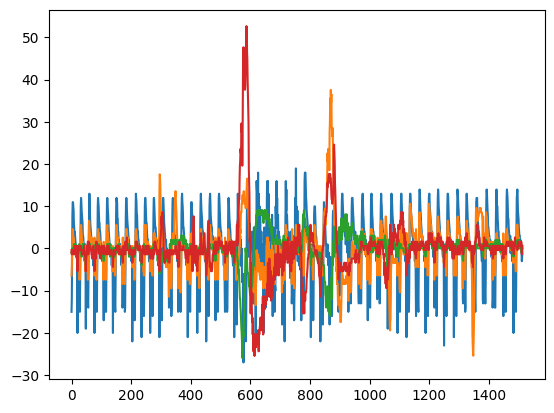

In [4]:
from scipy.signal import butter, sosfilt
def process_emg(emg_data):
    timestamp = emg_data[:, 0]
    emg_data = emg_data[:, 1:]
    emg_data = emg_data - np.mean(emg_data, axis=0)
    # emg_data = emg_data / np.std(emg_data, axis=0)
    bandpass_freq_low = 5
    bandpass_freq_high = 15
    lowpass_freq = 1
    butterworth_order = 4
    sampling_rate = len(emg_data) / (timestamp[-1] - timestamp[0]) * 1000
    window_length = 15

    def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], btype='band', output='sos')
        return sos


    def butter_bandpass_filter(data, lowcut, highcut, sample_rate, order=5):
        sos = butter_bandpass(lowcut, highcut, sample_rate, order=order)
        y = sosfilt(sos, data)
        return y

    plt.plot(emg_data)
    emg_data = butter_bandpass_filter(emg_data, bandpass_freq_low, bandpass_freq_high, sampling_rate, butterworth_order)
    window = np.ones(window_length) / window_length
    # Line 19: Compute the RMS envelope using convolution
    EMG = []
    for i in range(4):
        squared_emg = emg_data[:,i] ** 2
        val = np.sqrt(np.convolve(squared_emg, window, mode='same'))
        EMG.append(val)
    EMG = np.array(EMG).T
    
    def butter_lowpass_sos(cutoff, fs, order=5):
        nyquist = 0.5 * fs  # Nyquist Frequency
        normal_cutoff = cutoff / nyquist
        sos = butter(order, normal_cutoff, btype='low', analog=False, output='sos')
        return sos

    def sos_lowpass_filter(data, cutoff, fs, order=5):
        sos = butter_lowpass_sos(cutoff, fs, order=order)
        y = sosfilt(sos, data)
        return y
    EMG = sos_lowpass_filter(EMG, lowpass_freq, sampling_rate, butterworth_order)
    magnitude = np.mean(EMG, axis=0)
    result = np.sum(EMG, axis=1)
    return magnitude, result, timestamp
magnitude, result, timestamp = process_emg(emg_data)
    

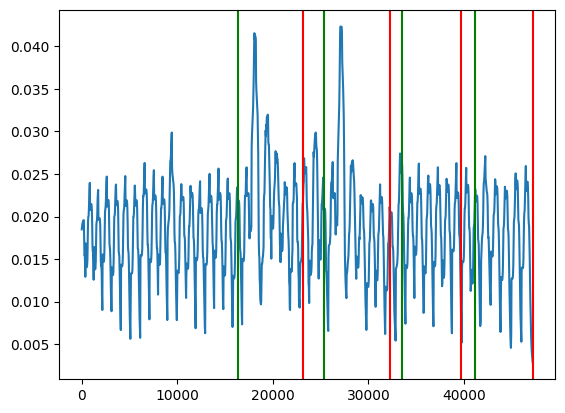

In [5]:
plt.plot(timestamp, result)
for s in timestamp_data['start']:
    plt.axvline(x=s, color='g')
for e in timestamp_data['end']:
    plt.axvline(x=e, color='r')

In [6]:
print(magnitude)

[9.86159720e-05 9.22560422e-04 4.27208968e-03 1.34399453e-02]
